In [1]:
%reload_ext nb_black

<IPython.core.display.Javascript object>

# 🏢 Chicago Salaries 💰

Chicago has public data on many job salaries of public servant type roles.  This data can be found [here](https://data.cityofchicago.org/Administration-Finance/Current-Employee-Names-Salaries-and-Position-Title/xzkq-xp2w).

### Warm Up 🥵

* What is `epsilon` used for in `SVR()`?
    * A) Another name for the coefficients
    * B) Handles trade off of over/under fitting
    * C) Allows to ignore errors of a certain magnitude
    * D) T U B E S
    
    
* What is `C` used for in SVR?
    * A) Another name for the coefficients
    * B) Handles trade off of over/under fitting
    * C) Allows to ignore errors of a certain magnitude
    * D) T U B E S
    
    
* If we randomly sample rows from the input data we've created a:
    * A) Bag = Bootstrap Aggregation
    * B) Bootstrap sample
    * C) Feature subspace
    * D) T U B E S
    
    
* If we randomly sample columns from the input data we've created a:
    * A) Bag
    * B) Bootstrap sample
    * C) Feature subspace
    * D) T U B E S
    
    
* If the 'depth' of a decision tree is too high, we'll be more likely to:
    * A) Overfit
    * B) Underfit
    
    
* Someone just interpreted a regression metric using the phrase: "On average, the model's predictions are within 10% of the right answer" Which metric were they probably interpreting?
    * A) MAE
    * B) MAPE
    * C) RMSE
    * D) R2


* The practice of combining multiple supervised machine learning models into one is known as:
    * A) Chorus
    * B) Ensemble
    * C) A cappella
    * D) Metallica

----


#### Boosting 🚀

Boosting is an 'ensembling' technique.

What does ensembling mean in the context of machine learning?

In boosting, we'll iteratively build models (aka build models in a series; aka build one model after another). The overview is.

1. Build a pretty dumb model (more typically called a 'weak learner')
   * In the below image doing classification, this is the first plot
* See where that model makes mistakes
* Build another model with a focus on not making the same mistakes again
   * In the image, this is the second/third grids.  The mistakes are enlarged in these to show that they're a priority.
* Repeat steps 1-3 as much as you want
* Combine the output of these models somehow
   * In the image, this is the final grid.


<img src='https://d1jnx9ba8s6j9r.cloudfront.net/blog/wp-content/uploads/2019/06/How-Does-Boosting-Algorithm-Work-Boosting-Machine-Learning-Edureka-min-528x254.png' width='50%'>

----

This image is focused on boosting in a regression setting.

<p align='center'><img src='https://i.imgur.com/RewteYv.png' width=70%></p>

## Data Import and EDA

In [2]:
# !pip install gender_guesser
import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor

from category_encoders import LeaveOneOutEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from gender_guesser.detector import Detector

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

<IPython.core.display.Javascript object>

In [3]:
# This is a direct link to the published data.
# The data might change (last updated Oct 2019)
# The data might be moved and this link might break
# A snapshot of the data can be found on kaggle:
# https://www.kaggle.com/chicago/chicago-citywide-payroll-data

# The commentary in this notebook also falls out of date pretty quickly... sorry
data_url = (
    "https://data.cityofchicago.org/api/views/xzkq-xp2w/rows.csv?accessType=DOWNLOAD"
)
chicago = pd.read_csv(data_url)

<IPython.core.display.Javascript object>

Do some general 'get to know you' EDA

In [4]:
chicago.head()

,Name,Job Titles,Department,Full or Part-Time,Salary or Hourly,Typical Hours,Annual Salary,Hourly Rate
0,"AARON, JEFFERY M",SERGEANT,POLICE,F,Salary,NaN,111444.0,NaN
1,"AARON, KARINA",POLICE OFFICER (ASSIGNED AS DETECTIVE),POLICE,F,Salary,NaN,94122.0,NaN
2,"AARON, KIMBERLEI R",CHIEF CONTRACT EXPEDITER,DAIS,F,Salary,NaN,118608.0,NaN
3,"ABAD JR, VICENTE M",CIVIL ENGINEER IV,WATER MGMNT,F,Salary,NaN,117072.0,NaN
4,"ABARCA, EMMANUEL",CONCRETE LABORER,TRANSPORTN,F,Hourly,40.0,NaN,44.4


<IPython.core.display.Javascript object>

In [5]:
chicago.dtypes

Name                  object
Job Titles            object
Department            object
Full or Part-Time     object
Salary or Hourly      object
Typical Hours        float64
Annual Salary        float64
Hourly Rate          float64
dtype: object

<IPython.core.display.Javascript object>

If you didn't already run an `np.nan` check, do one now to show the percent of missing values by column

In [6]:
chicago.isna().mean()

Name                 0.000000
Job Titles           0.000000
Department           0.000000
Full or Part-Time    0.000000
Salary or Hourly     0.000000
Typical Hours        0.768252
Annual Salary        0.231748
Hourly Rate          0.768252
dtype: float64

<IPython.core.display.Javascript object>

Those percents look suspiciously related...

Let's say we want to only predict salary, drop hourly data from the dataset and re-check for missing values.

In [7]:
chicago = chicago[chicago["Salary or Hourly"] == "Salary"]

<IPython.core.display.Javascript object>

We now see that the missing values were directly related to the `'Salary or Hourly'` distinction.  We can now drop some columns that don't give us any info going forward.

In [8]:
drop_cols = ["Salary or Hourly", "Typical Hours", "Hourly Rate"]
chicago = chicago.drop(columns=drop_cols)
chicago.head()

,Name,Job Titles,Department,Full or Part-Time,Annual Salary
0,"AARON, JEFFERY M",SERGEANT,POLICE,F,111444.0
1,"AARON, KARINA",POLICE OFFICER (ASSIGNED AS DETECTIVE),POLICE,F,94122.0
2,"AARON, KIMBERLEI R",CHIEF CONTRACT EXPEDITER,DAIS,F,118608.0
3,"ABAD JR, VICENTE M",CIVIL ENGINEER IV,WATER MGMNT,F,117072.0
5,"ABARCA, FRANCES J",POLICE OFFICER,POLICE,F,68616.0


<IPython.core.display.Javascript object>

All categorical variables... 

Filter the dataframe to just full-time workers and drop the `'Full or Part-Time'` column.

In [9]:
chicago = chicago[chicago["Full or Part-Time"] == "F"]
chicago = chicago.drop(columns="Full or Part-Time")

<IPython.core.display.Javascript object>

If there are any NAs remaining in the salary column, drop them.

In [10]:
chicago = chicago.dropna()

<IPython.core.display.Javascript object>

In general, names aren't too informative for prediction.  BUT! We don't have a lot of features here, we probably want to put our feature engineering hats on.

* Maybe we wanted to investigate nepotism, if that was the case, name could be valuable and we might want to restrict to surname...
* Maybe we want to investigate if there's a gender pay gap in our data.  To do this we might try and guess the gender of the person based on their first name.  This, of course, won't be too accurate... but it's kind of neat that we can try to do this.
    * Note, this type of feature is definitely a stretch, we're surely introducing bias.  This type of feature might not be good to use in practice (unless you're going after some click bait style analysis: "Are Bradley's really paid more??").  

Let's go down this maybe ill advised rabbit trail of engineering a gender column.

First, we need to isolate first name.  Below are some example names in the form we'll be working with in the dataframe. However, before we think about doing this in pandas, let's figure out how to isolate the name in a string.  

Write some code to extract the first names.

In [11]:
name = "ADRIANO,  RACQUEL ANNE"  # Expected output: 'RACQUEL'
# name = 'AFFANEH,  MAHIR A'       # Expected output: 'MAHIR'
# name = 'SPANNBAUER, ADAM M'      # Expected output: 'ADAM'

<IPython.core.display.Javascript object>

In [12]:
name.split(",  ")

['ADRIANO', 'RACQUEL ANNE']

<IPython.core.display.Javascript object>

In [13]:
first_middle = name.split(",  ")[-1]
first_middle

'RACQUEL ANNE'

<IPython.core.display.Javascript object>

In [14]:
first_middle.split(" ")

['RACQUEL', 'ANNE']

<IPython.core.display.Javascript object>

In [15]:
first = first_middle.split(" ")[0]
first

'RACQUEL'

<IPython.core.display.Javascript object>

Now translate this to pandas and apply it to the `'Name'` column

In [16]:
first_middle = chicago["Name"].str.split(",  ").str[-1]
first = first_middle.str.split(" ").str[0]
first

0          JEFFERY
1           KARINA
2        KIMBERLEI
3          VICENTE
5          FRANCES
           ...    
32923      KLAUDIA
32924        LAURA
32925         MARK
32926        CARLO
32927      DARIUSZ
Name: Name, Length: 25296, dtype: object

<IPython.core.display.Javascript object>

We prolly want this as a function so we can hide away all this logic.

In [17]:
def get_first_name(chitown_names):
    first_middle = chitown_names.str.split(",  ").str[-1]
    first = first_middle.str.split(" ").str[0]
    return first

<IPython.core.display.Javascript object>

In [18]:
chicago["First Name"] = get_first_name(chicago["Name"])
chicago.head()

,Name,Job Titles,Department,Annual Salary,First Name
0,"AARON, JEFFERY M",SERGEANT,POLICE,111444.0,JEFFERY
1,"AARON, KARINA",POLICE OFFICER (ASSIGNED AS DETECTIVE),POLICE,94122.0,KARINA
2,"AARON, KIMBERLEI R",CHIEF CONTRACT EXPEDITER,DAIS,118608.0,KIMBERLEI
3,"ABAD JR, VICENTE M",CIVIL ENGINEER IV,WATER MGMNT,117072.0,VICENTE
5,"ABARCA, FRANCES J",POLICE OFFICER,POLICE,68616.0,FRANCES


<IPython.core.display.Javascript object>

Now we need to classify these as male/female... A couple ways we could do this:

* Find a database (like Social Security or something idk) of names by gender and look up the names and label with the most common
* Use a model trained on a database like this to make predictions
   * ^One of those is `pip` installable (`!pip install gender_guesser`)
   
Below is an example on how to use it.

In [19]:
# from gender_guesser.detector import Detector

gd = Detector()
print("Title case:")
print(gd.get_gender("Candy"))
print(gd.get_gender("Scott"))
print(gd.get_gender("Tonks"))  # my dog's name (she's a lady)

# It doesn't know how to handle casing...
print("\nUpper case:")
print(gd.get_gender("CANDY"))
print(gd.get_gender("SCOTT"))
print(gd.get_gender("TONKS"))

Title case:
female
male
unknown

Upper case:
unknown
unknown
unknown


<IPython.core.display.Javascript object>

We need to change our first names to title case to get predictions it seems.

In [20]:
# Example in string land
"THE GREAT GATSBY".title()

'The Great Gatsby'

<IPython.core.display.Javascript object>

Apply title casing the the first names in the dataframe

In [21]:
chicago["First Name"] = chicago["First Name"].str.title()
chicago.head()

,Name,Job Titles,Department,Annual Salary,First Name
0,"AARON, JEFFERY M",SERGEANT,POLICE,111444.0,Jeffery
1,"AARON, KARINA",POLICE OFFICER (ASSIGNED AS DETECTIVE),POLICE,94122.0,Karina
2,"AARON, KIMBERLEI R",CHIEF CONTRACT EXPEDITER,DAIS,118608.0,Kimberlei
3,"ABAD JR, VICENTE M",CIVIL ENGINEER IV,WATER MGMNT,117072.0,Vicente
5,"ABARCA, FRANCES J",POLICE OFFICER,POLICE,68616.0,Frances


<IPython.core.display.Javascript object>

Create a new column named `'gender_guess'` by applying the `gd.get_gender` to the title cased first name column

In [22]:
chicago["gender_guess"] = chicago["First Name"].apply(gd.get_gender)
chicago.head()

,Name,Job Titles,Department,Annual Salary,First Name,gender_guess
0,"AARON, JEFFERY M",SERGEANT,POLICE,111444.0,Jeffery,male
1,"AARON, KARINA",POLICE OFFICER (ASSIGNED AS DETECTIVE),POLICE,94122.0,Karina,female
2,"AARON, KIMBERLEI R",CHIEF CONTRACT EXPEDITER,DAIS,118608.0,Kimberlei,unknown
3,"ABAD JR, VICENTE M",CIVIL ENGINEER IV,WATER MGMNT,117072.0,Vicente,male
5,"ABARCA, FRANCES J",POLICE OFFICER,POLICE,68616.0,Frances,female


<IPython.core.display.Javascript object>

We can now drop our name columns (unless we (1) wanted to investigate nepotism, (2) check if bradley's make more money, or something else name related).

In [23]:
drop_cols = ["Name", "First Name"]
chicago = chicago.drop(columns=drop_cols)

<IPython.core.display.Javascript object>

Create a violin plot of `'Annual Salary'` by `'gender_guess'`.

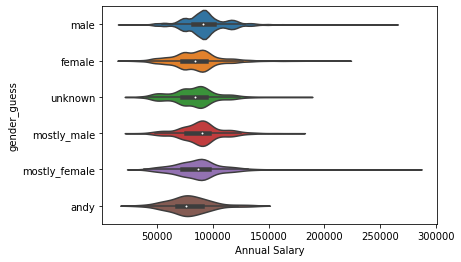

<IPython.core.display.Javascript object>

In [24]:
sns.violinplot("Annual Salary", "gender_guess", data=chicago)
plt.show()

Ah, of course, the very often forgotten gender, 'andy'.

Per documentation, andy is their shorthand for androgynous.  Let's collapse down to 3 categories: male, female, other.

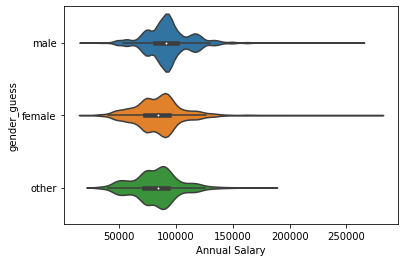

<IPython.core.display.Javascript object>

In [25]:
replacements = {
    "mostly_male": "male",
    "mostly_female": "female",
    "unknown": "other",
    "andy": "other",
}

chicago["gender_guess"] = chicago["gender_guess"].replace(replacements)

sns.violinplot("Annual Salary", "gender_guess", data=chicago)
plt.show()

💥BOOM 💥 new feature is now engineered.  Let's get back to some more on topic stuff.

Look at the value counts for `'Job Titles'` and `'Department'`.  Spoiler, there's a lot, create an 'other' category for both.  Decide some cutoff point for what's too few (threshold by count, threshold by count percentile, take the top n, etc.)

In [26]:
chicago["Job Titles"].value_counts()

POLICE OFFICER                            9557
FIREFIGHTER-EMT                           1411
SERGEANT                                  1296
POLICE OFFICER (ASSIGNED AS DETECTIVE)    1136
FIREFIGHTER-EMT (RECRUIT)                  490
                                          ... 
SUPERVISING AUDIO-VISION TESTER              1
MANAGING EDITOR COUNCIL JOURNAL              1
DEPUTY PRESS SECRETARY                       1
FIRE PREVENTION ENGINEER                     1
ASST MANAGER  OF COLLECTIONS                 1
Name: Job Titles, Length: 969, dtype: int64

<IPython.core.display.Javascript object>

In [27]:
def create_other_cat(df, col, thresh):
    df = df.copy()

    counts = df[col].value_counts()
    lo_counts = counts[counts < thresh]
    lo_count_ids = lo_counts.index
    lo_count_filter = df[col].isin(lo_count_ids)

    df.loc[lo_count_filter, col] = "Other"

    return df

<IPython.core.display.Javascript object>

In [28]:
chicago = create_other_cat(df=chicago, col="Job Titles", thresh=10)
chicago = create_other_cat(df=chicago, col="Department", thresh=10)

<IPython.core.display.Javascript object>

In [29]:
chicago["Job Titles"].value_counts()

POLICE OFFICER                            9557
Other                                     2082
FIREFIGHTER-EMT                           1411
SERGEANT                                  1296
POLICE OFFICER (ASSIGNED AS DETECTIVE)    1136
                                          ... 
CERTIFICATION - COMPLIANCE OFFICER          10
STAFF ASSISTANT - EXCLUDED                  10
PROGRAM DIR - CULTURAL AFFAIRS              10
SUPERVISING PARALEGAL                       10
ASST DEPUTY CHIEF PARAMEDIC                 10
Name: Job Titles, Length: 210, dtype: int64

<IPython.core.display.Javascript object>

## Model Prep

Perform a train test split stratified by our gender guess feature.

In [30]:
chicago.head()

,Job Titles,Department,Annual Salary,gender_guess
0,SERGEANT,POLICE,111444.0,male
1,POLICE OFFICER (ASSIGNED AS DETECTIVE),POLICE,94122.0,female
2,CHIEF CONTRACT EXPEDITER,DAIS,118608.0,other
3,CIVIL ENGINEER IV,WATER MGMNT,117072.0,male
5,POLICE OFFICER,POLICE,68616.0,female


<IPython.core.display.Javascript object>

In [31]:
X = chicago.drop(columns=["Annual Salary"])
y = chicago["Annual Salary"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=chicago["gender_guess"],
)

<IPython.core.display.Javascript object>

In [32]:
bin_cols = []
cat_cols = ["Job Titles", "Department", "gender_guess"]
num_cols = []

<IPython.core.display.Javascript object>

Our `X` data is all categories; let's use the `LeaveOneOutEncoder()`.  If we get poor performance we can come back and drop in a `OneHotEncoder()` with relatively small effort.

* Complete the `ColumnTransformer` & `Pipeline`
* Fit the pipeline to the training data
* Report the scores for the training and testing data

In [33]:
# fmt: off
preprocessing = ColumnTransformer([
    ('cat_encode', LeaveOneOutEncoder(), cat_cols)
])
# fmt: on

<IPython.core.display.Javascript object>

In [34]:
# fmt: off
pipeline = Pipeline([
    ('preprocessing', preprocessing),
    ('gbr', GradientBoostingRegressor())
])
# fmt: on

pipeline.fit(X_train, y_train)

train_score = pipeline.score(X_train, y_train)
test_score = pipeline.score(X_test, y_test)

print(f"train_score {train_score}")
print(f"test_score {test_score}")

train_score 0.46687241597065554
test_score 0.4769013889232959


<IPython.core.display.Javascript object>

Extract the `.feature_importances_` from the gbtree regressor in your pipeline.  What was most important?

In [35]:
importance_df = pd.DataFrame(
    {
        "feat": X_train.columns,
        "importance": pipeline.named_steps["gbr"].feature_importances_,
    }
)

importance_df.sort_values("importance", ascending=False)

,feat,importance
0,Job Titles,0.746359
2,gender_guess,0.220947
1,Department,0.032694


<IPython.core.display.Javascript object>

A pretty smart guy said this is his parameter grid for this model type. (the names don't line up with sklearn's names).

<img src='https://i.stack.imgur.com/9GgQK.jpg' width='70%'>

* Grid search some hyperparams to increase performance
* Print out the best parameters from the CV

In [36]:
# Adjusted max_features/max_depth to have smaller grid
grid = {
    "gbr__subsample": [0.5, 0.75, 1.0],
    #     "gbr__max_features": [0.5, 0.75, 1.0], # alternative
    "gbr__max_features": [0.4, 0.6, 0.8, 1.0],
    "gbr__max_depth": [3, 4, 6],
}

n_trees = 100
learning_rate = 2 / n_trees

# fmt: off
pipeline = Pipeline([
    ("preprocessing", preprocessing),
    ("gbr", GradientBoostingRegressor(n_estimators=n_trees, 
                                      learning_rate=learning_rate))
])
# fmt: on

pipeline_cv = GridSearchCV(pipeline, grid, verbose=1, cv=2, n_jobs=-1)
pipeline_cv.fit(X_train, y_train)

pipeline_cv.best_params_

Fitting 2 folds for each of 36 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:   11.0s finished


{'gbr__max_depth': 3, 'gbr__max_features': 1.0, 'gbr__subsample': 1.0}

<IPython.core.display.Javascript object>

Print out the train and test scores

In [37]:
train_score = pipeline_cv.score(X_train, y_train)
test_score = pipeline_cv.score(X_test, y_test)

print(f"train_score {train_score}")
print(f"test_score {test_score}")

train_score 0.5577367518168934
test_score 0.5602191319733977


<IPython.core.display.Javascript object>

Extract the `.feature_importances_` from the gbtree regressor in your pipeline.  What was most important?

In [38]:
best_pipeline = pipeline_cv.best_estimator_
feat_importances = best_pipeline.named_steps["gbr"].feature_importances_

<IPython.core.display.Javascript object>

In [39]:
importance_df = pd.DataFrame({"feat": X_train.columns, "importance": feat_importances})

importance_df.sort_values("importance", ascending=False)

,feat,importance
0,Job Titles,0.818921
2,gender_guess,0.133948
1,Department,0.047132


<IPython.core.display.Javascript object>